In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

from esm.models.esmc import ESMC

from esm.sdk.api import ESMProtein, LogitsConfig

protein = ESMProtein(sequence="AAAAA")
client = ESMC.from_pretrained("esmc_300m").to("cuda") # or "cpu"
protein_tensor = client.encode(protein)
logits_output = client.logits(
   protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
)
print(logits_output.logits, logits_output.embeddings)

/home/rathavale/miniconda3/envs/b3esm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rathavale/miniconda3/envs/b3esm/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 21076.90it/s]
/home/rathavale/miniconda3/envs/b3esm/lib/python3.10/site-packages/esm/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_onl

ForwardTrackData(sequence=tensor([[[-38.2500, -38.0000, -38.0000,  12.5625,  21.6250,  22.2500,  22.0000,
           21.7500,  21.3750,  21.6250,  21.6250,  21.2500,  20.7500,  21.3750,
           21.8750,  20.8750,  20.7500,  20.2500,  20.3750,  20.1250,  21.7500,
           19.7500,  19.7500,  19.2500,  18.3750,   1.1641,  -1.8047,  -4.0312,
          -20.6250, -38.2500, -38.0000, -38.0000, -38.2500, -38.2500, -38.2500,
          -38.2500, -38.2500, -38.0000, -38.2500, -38.0000, -38.2500, -38.2500,
          -38.2500, -38.0000, -38.0000, -38.2500, -38.2500, -38.2500, -38.2500,
          -38.2500, -38.2500, -38.2500, -38.0000, -38.2500, -38.2500, -38.0000,
          -38.2500, -38.0000, -38.2500, -38.0000, -38.2500, -38.2500, -38.2500,
          -38.2500],
         [-40.0000, -40.0000, -40.2500,   5.3438,  20.1250,  20.0000,  18.7500,
           20.6250,  18.7500,  18.3750,  18.6250,  18.5000,  18.2500,  18.0000,
           18.7500,  17.7500,  17.3750,  17.1250,  17.7500,  16.8750,  22

In [27]:
import pandas as pd

def parse_protein_data(file_path):
    """
    Parses a protein data file to extract sequences and numbers into a pandas DataFrame.
    
    Parameters:
        file_path (str): Path to the input file containing the protein data.
    
    Returns:
        pd.DataFrame: DataFrame with 'Sequence' and 'Number' columns.
    """
    # Read file content
    with open(file_path, 'r') as file:
        data = file.read()

    # Split data into blocks by '>'
    entries = [entry.strip() for entry in data.split('>') if entry.strip()]

    # Prepare lists for parsed values
    sequences = []
    numbers = []

    # Extract sequence and number from each block
    for entry in entries:
        lines = entry.splitlines()              # Split each block into lines
        sequence = lines[1].strip()             # Sequence: second line
        label = lines[0].split('|')
        number = int(label[1].strip())         # Number: last line
        sequences.append(sequence)
        numbers.append(number)

    # Convert parsed data into a pandas DataFrame
    df = pd.DataFrame({
        'Sequence': sequences,
        'Number': numbers
    })
    
    return df

In [28]:
train_path = 'Training.txt'
val_path = 'Validing.txt'

# Parse the data and get a DataFrame
data_train = parse_protein_data(train_path)
data_val = parse_protein_data(val_path)

# Output the DataFrame
display(data_train)

,Sequence,Number
0,GKRPK,0
1,KCCKG,0
2,LLELL,0
3,KVRKE,0
4,LVAWS,0
...,...,...
2846,RPRTRLHTHRNRRPRTRLHTHRNR,1
2847,YGRKKRRQRRRMKSNGSFPVNRRRMD,1
2848,HSDGIFTDSYSRYRKQMAVKKYLAAVL,1
2849,GSSFLSPEHQKAQQRKESKKPPAKLQPR,1


In [29]:
def create_fasta_file(input_file, output_file):
    """
    Converts sequences from a text file to a FASTA format file.

    Args:
        input_file (str): Path to the input text file containing sequences.
        output_file (str): Path to the output FASTA file.
    """
    try:
        with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
            for i, line in enumerate(infile):
                # Strip unnecessary whitespace and process line
                sequence = line.strip()
                if sequence:  # Skip empty lines
                    # Write in FASTA format
                    outfile.write(f">Seq{i+1}\n{sequence}\n")
        print(f"FASTA file created at: {output_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

# File paths
input_file = "Training.txt"  # Replace with the path to your input file
output_file = "sequences.fasta"  # Output file path for the FASTA file

# Generate the FASTA file
create_fasta_file(input_file, output_file)


FASTA file created at: sequences.fasta


In [30]:
from tqdm.auto import tqdm

# Function to compute embeddings and append to the DataFrame
def add_protein_embeddings(df, model):
    """
    Adds protein embeddings to a DataFrame containing sequences.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'Sequence' and 'Number' columns.
        model: Pretrained ESMC model instance.
    
    Returns:
        pd.DataFrame: Updated DataFrame with an 'Embeddings' column.
    """
    embeddings = []
    for sequence in tqdm(df['Sequence']):
        protein = ESMProtein(sequence=sequence)
        protein_tensor = model.encode(protein)
        logits_output = model.logits(protein_tensor, LogitsConfig(sequence=True, return_embeddings=True))
        embeddings.append(logits_output.embeddings.detach().cpu().numpy())  # Convert embeddings to numpy
    df['Embeddings'] = embeddings
    return df

data_train = add_protein_embeddings(data_train, client)
data_val = add_protein_embeddings(data_val, client)

100%|██████████| 108/108 [00:07<00:00, 14.84it/s]


In [31]:
data_train.to_pickle("/data/b3esm/data_train.pkl")
data_val.to_pickle("/data/b3esm/data_val.pkl")

In [32]:
data_train.to_pickle("data_train.pkl")
data_val.to_pickle("data_val.pkl")

/home/rathavale/miniconda3/envs/b3esm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


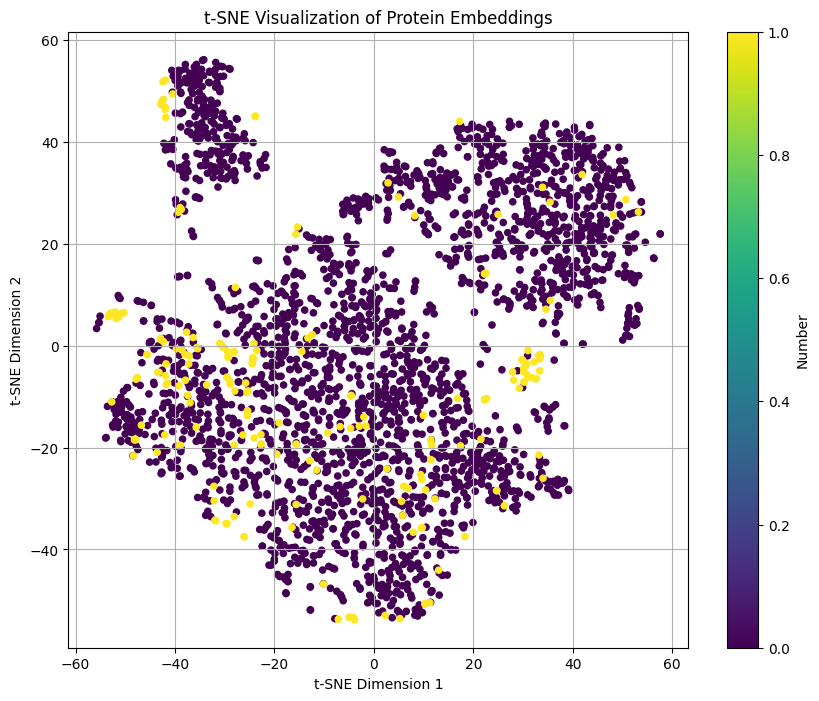

In [43]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(data, perplexity=30, learning_rate=200, n_iter=1000):
    """
    Creates and plots a t-SNE visualization of the embeddings in the data.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'Embeddings' as a column.
        perplexity (float): t-SNE perplexity parameter.
        learning_rate (float): t-SNE learning rate parameter.
        n_iter (int): Number of iterations for optimization.

    Returns:
        None: Displays the t-SNE plot.
    """
    # Extract embeddings and labels
    embeddings = data['Embeddings'].to_numpy()
    embeddings = np.array([e.mean(axis=1).reshape(-1,) for e in embeddings])
    numbers = data['Number']

    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=numbers, cmap='viridis', s=20)
    plt.colorbar(scatter, label="Number")
    plt.title("t-SNE Visualization of Protein Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

# Assuming `data_train` contains the embeddings
plot_tsne(data_train, perplexity=30, learning_rate=200, n_iter=1000)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def train_knn_classifier(data, val_data, n_neighbors=5):
    """
    Trains a kNN classifier on protein embeddings.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'Embeddings' and 'Number'.
        n_neighbors (int): Number of neighbors for the kNN classifier.

    Returns:
        model (KNeighborsClassifier): Trained kNN model.
        X_train, X_test, y_train, y_test (tuple): Train/test data splits.
    """
    # Process embeddings: take mean along token axis (axis=1)
    embeddings = data['Embeddings'].to_numpy()
    X = np.array([e.mean(axis=1).reshape(-1,) for e in embeddings])
    
    # Extract labels
    y = data['Number'].to_numpy()

    embeddings_val = val_data['Embeddings'].to_numpy()
    X_val = np.array([e.mean(axis=1).reshape(-1,) for e in embeddings_val])
    
    # Extract labels
    y_val = val_data['Number'].to_numpy()
    
    # Split data into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train kNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # Evaluate classifier
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"kNN Classifier Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return knn, X_train, X_test, y_train, y_test

# Train the kNN classifier
knn_model, X_train, X_test, y_train, y_test = train_knn_classifier(data_train, data_val, n_neighbors=5)

kNN Classifier Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       528
           1       0.58      0.33      0.42        43

    accuracy                           0.93       571
   macro avg       0.77      0.65      0.69       571
weighted avg       0.92      0.93      0.92       571



In [1]:
from data.datasets import B3ESMDataset

In [25]:
from sklearn.decomposition import PCA
from copy import deepcopy

pca_model = PCA(n_components=100)
train_data = B3ESMDataset(split='train', augs=['mean', 'smote', 'pca'], pca_model=pca_model)
comps = deepcopy(pca_model.components_)
train_comps = deepcopy(train_data.pca_model.components_)
# val_data = B3ESMDataset(split='val', augs=['mean', 'smote', 'pca'], pca_model=pca_model)

(2851, 960) (2851, 1)


In [26]:
val_data = B3ESMDataset(split='val', augs=['mean', 'smote', 'pca'], pca_model=pca_model)
val_comps = deepcopy(val_data.pca_model.components_)

In [32]:
(comps == val_comps).sum() - train_comps.size

0

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def train_knn_classifier(train_x, train_y, val_x, val_y, n_neighbors=5):
    """
    Trains a kNN classifier on protein embeddings.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'Embeddings' and 'Number'.
        n_neighbors (int): Number of neighbors for the kNN classifier.

    Returns:
        model (KNeighborsClassifier): Trained kNN model.
        X_train, X_test, y_train, y_test (tuple): Train/test data splits.
    """
    # Process embeddings: take mean along token axis (axis=1)
    embeddings = np.array(train_x)
    # X = np.array([e.mean(axis=1).reshape(-1,) for e in embeddings])
    X_train = embeddings
    
    # Extract labels
    y_train = np.array(train_y)

    embeddings_val = np.array(val_x)
    # X_val = np.array([e.mean(axis=1).reshape(-1,) for e in embeddings_val])
    X_test = embeddings_val
    
    # Extract labels
    y_test = np.array(val_y)
    
    # Split data into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train kNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # Evaluate classifier
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"kNN Classifier Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return knn, X_train, X_test, y_train, y_test

# Train the kNN classifier
knn_model, X_train, X_test, y_train, y_test = train_knn_classifier(train_data.embeds, train_data.labels, val_data.embeds, val_data.labels, n_neighbors=5)

kNN Classifier Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80        54
         1.0       0.79      0.83      0.81        54

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.81      0.81      0.81       108

